# 03 - Classification

In [1]:
#Common Imports
import numpy as np
np.random.seed(42)

sklearn has datasets and they all follow a similar dictionary structure as follows

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data consists of 70k, 28x28 images, with intensity ranging from 0 (white) to 255 (black)

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

To generate an image from an instance, use Matplotlib's `imshow()`

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

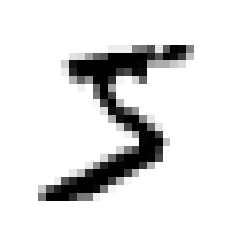

In [6]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Check label

In [7]:
y[0]

'5'

Useful to cast string label into an integer (unsigned, 8 bit [0,255])

In [8]:
y = y.astype(np.uint8)

Should always create a test set (and set it aside) before inspecting the data as a whole (to avoid brain's *snooping bias*). In this case, train/test has already been shuffled and split into the first 60k from sklearn. Recall considerations like stratified sampling, and in this case, similar examples in mass back to back

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

First lets simplify it and classify based on two classes, 5's of not 5's.

In [10]:
y_train_5 = (y_train == 5) # True for all 5's, false otherwise
y_test_5 = (y_test == 5)

Elect to use a stochastic gradient descent classifier. Recall SGD is a sequential update method for the model params $(\mathbf w^{(\tau+1)} = \mathbf w^{(\tau)} - \eta \nabla E_n)$

In [11]:
from sklearn.linear_model import SGDClassifier

# epochs = 1000, loss stop = tol
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

Many performance measures in classification as compared to regression

### Measuring Accuracy Using Cross-Validation

Nice implementation of cross-validation from scratch that achieves the same result as built-in sklearn `cross_val_scrore`; useful if one needs to fine tune K-fold cross val. (pg 89)

In [13]:
from sklearn.model_selection import cross_val_score
# returns ratio of correct predictions
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Caution to interpret as good classifier, since 5's only constitute a small portion of overall dataset. Let's compare to one that classifies everything as a non-5. 

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Demonstrates issue using accuracy in *skewed* dataset (in conjunction with binary classification)

### Confusion Matrix

Better to evaluate classifier performance using *confusion matrix*, which counts the number of times instances of a class *A* are classfied as class *B*

Remember not to touch test set yet. First generate predictions, then generate confusion matrix via:

In [16]:
from sklearn.model_selection import cross_val_predict
# can also perform cross validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Rows represent actual classes (must have a basis of comparison), columns represent predicted class

[ true negative, false positive], [false negative, true positive]

In [18]:
y_train_perfect_pred = y_train_5 #pretend perfection
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

More concise to work with *precision* and *recall*, which look at relative accuracies from confusion matrix
$$ precision = \frac{TP}{TP + FP}$$
Precision can be trivially achieved by predicting a single TP result, and classifier rest as negative. Thus we should also include *recall* (aka *sensitivity*, *true positive rate (TPR)*)
$$ recall = \frac{TP}{TP + FN}$$

In [19]:
from sklearn.metrics import precision_score, recall_score

# When it claims an image is a 5, only predicts correctly 83% of the time
# (Given a prediction of 5, only 83% accurate)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
# Only detects 65% of the 5's
# (Given the image is a 5, 65% prediction accuracy)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Conveinent to assign single score using precision and recall, called *F_1 score*. It is the harmonic mean of precision and recall, giving larger weight to lower score. Harmonic mean is the reciprocal of the arithmetic mean of the reciprocals of a given set of observations. Useful for calculating averages of rates and ratios (e.g. scenario of traveling a distance *d* at speed *x* outboud and traveling same distance *d* at speed *y* inbound. Different speeds imply different trip times, so what is really the average speed? It is not the arithmetic mean, but rather $\frac{total\_distance\_traveled}{total\_time} = \frac{2d}{d/x + d/y} = \frac{2}{1/x + 1/y}$)

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F_1 classifier favors similar precision and recall. Not always ideal, depends hevaily upon design goals given data, factoring in weightings for false positives and so forth.  

### Precision/Recall Trade-Off

Increasing precision decreases recall, vice versa. Good graphical illustration on pg 94. As in code comment, think of precision as the following: given a *prediction* of 5, what is the fraction of true 5's. Recall : given an *actual* 5, what is the fraction of those correctly predicted. Classifiers are (often) based on decision functions that assign classes based on a probability threshold. Lowering such a threshold increases the recall (most 5's are captured) but at the expense of decreased precision (many more misclassified 5's). Raising such a threshold increases the precision (become much more sure of the 5's that are captured), but decreases the recall (however we increase chance of now missing other possible 5's). 

Cannot set threshold directly through sklearn but can access decision function.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

How to decide threshold? Use `cross_val_predict` to return decision function outputs

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now plot with `precision_recall_curve` function, which computes precision and recall for all possible thresholds

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

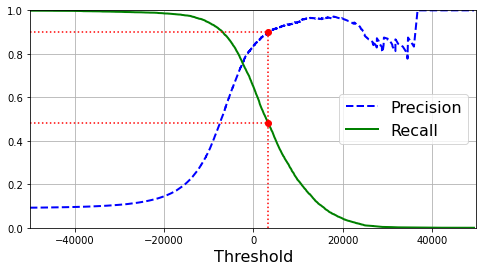

In [26]:
# Matplotlib plotting fn, details not too important

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Recall can only go down with increased threshold, however precision can get bumpy when increasing threshold where prior many positives were just slightly above threshold.

We could also plot precision directly against recall

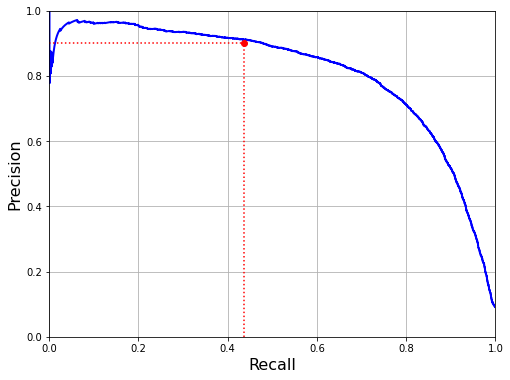

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

Around recall=0.8, precision rapidly drops off, thus want to select threshold before exponential decay.

Assume we desire 90% precision. `np.argmax` gives indices of maximum values. If multiple max values, returns first index.

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_predict_90 = (y_scores >= threshold_90_precision)
y_train_predict_90

array([False, False, False, ...,  True, False, False])

In [30]:
precision_score(y_train_5, y_train_predict_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_predict_90)

0.4799852425751706

Have now trained a classifier with 90% precision (or any adjustable precision)! One only need to worry whether recall may be too small

### The ROC Curve

*reciever operating characteristic* curve, tool used among binary classifiers. Similar to precision recall curve but plots true positive rate (recall, sensitivity) vs false positive rate (fall-out). $FPR = 1 - TNR = \frac{FP}{FP + TN}$, $TNR = \frac{TN}{TN+FP}$ (sensitivity). Too much terminology.  

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

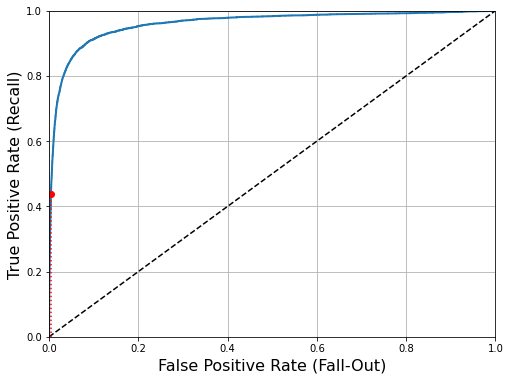

In [33]:
# Plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

Top left corner desirable. Truly random classifier falls along dotted line. Inherent tradeoff between TPR and FPR evident. A single performance metric could be to integrate the function, with the range falling between [0.5, 1] for a random and perfect classifier respectively. (AUC area under curve)

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Between the ROC curve and the PR curvve, use PR when positive class is sparse or when false positives are important. 

Let us now compare ROC between a random forest classifier and the SGD classifier. Random forests have a `predict_proba` as compared to `decision_function` (Ch. 7). (In fact sklearn classifiers usually have one or the other, or both). `predict_proba` returns array of instances (rows) and classes (columns) of probability said instance belongs to a given class. 

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
# ROC curve needs labels and scores; use proba. of positive class as scores
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

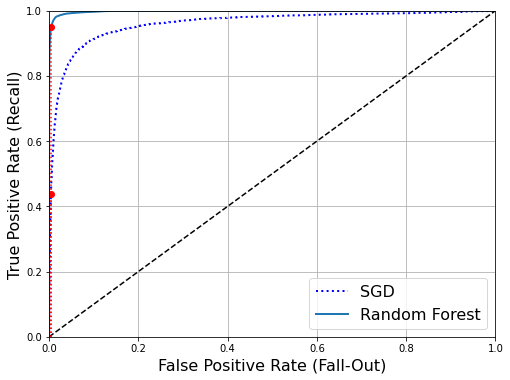

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

PR scores are also higher for random forest classifier.

## Multiclass Classification

SGD, random forest, and naive Bayes classifiers can natively support multiple classes. Binary classifiers like logistic regression and SVM require some tweaking. 

One method is to use a system of separate binary classifiers for each digit, taking the output of the one with highest score (one vs. the rest OvR). Similarly, one might use a set of classifiers for each pair of digits (one vs. one OvO), which needs $\begin{pmatrix}N\\2\end{pmatrix} = N(N-1)/2 \sim \mathcal O(n^2)$ classifiers. Training sets for OvO are, however, much smaller. 

SVM scales poorly with dataset size, thus OvO better choice (faster to train more classifiers on smaller datasets than opposite). Generally, OvR preferred method for binary classifiers (doing mutliclassification). 

sklearn with automatically select OvR or OvO when trying to use binary class. to do multi. class.

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, the above uses OvO, training $N(N-1)/2 = 45$ classifiers, generating decision scores and selecting class which won most duals. 

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

To explicitly use OvR or OvO, create `OneVsOneClassifier` or `OneVsRestClassifier` classes and pass in classifier as constructor (not limited to binary classifiers)

In [43]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

Can easily train SGD classifier (no need for Ov_)

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Decision function returns one value per class

In [46]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Pretty good. Random classifier would have accuracy of 10%. Scaling inputs (simple) would help improve accuracy. 

In [48]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64)) # Should have been np.float64 prior, hm.. 
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

At this stage, one should follow steps in ML project checklist (Appendix B), exploring data prep methods, evaluating multiple models, shortlisting best ones, finetuning hyperparams, and automating. Now we assume we have found a promising model and seek to improve it. Let's investigate its errors.

In [49]:
# Generate confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

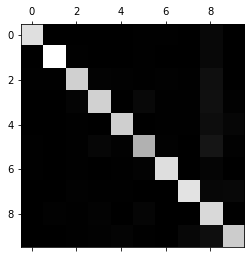

In [50]:
# Image representation even better
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Note that 5 is a little darker than others, indicating a) possibly less 5's to sample from or b) poor at classifying 5's. To better quantify confusion matrix output, we may look at 'error rates', i.e. the number of correct predictions of 5 given all possible 5's (analogous to binary TPR).

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums # Normalized by total number of actual instances in a given class

We elect to focus only on *errors* (analogous to binary TNR) and hence ignore the diagonals (which are comprised of anal. TPR's).

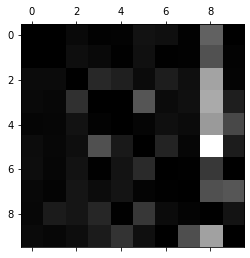

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Note asymmetry in confusion matrix. In analying individual errors, we can see difficulty in predicting 8's.

Methods of improvement may include a) gather more training data for images that look like 8's b) engineer new features (e.g. counting closed loop strokes) c) preprocess images making some patterns (e.g. closed loops) stand out more (rotate and center) 

Continuing individual error analysis (although time consuming), lets look at misclassified 3's and 5's. Left two boxes are classified as 3's and right two as 5's. 

In [55]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [65]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

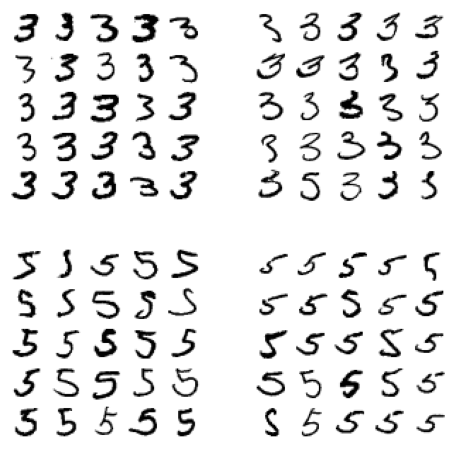

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

While there are a couple instances that are difficult on a human-level, we can see that most errors are obvious at human level. Main reason being overly-simple `SGDClassifier` linear model (each pixel is assigned 10 weights (one per class); entire image is summation of pixel weights, leading to one output per class; implies images that differ by only a couple pixels (3's and 5's), will be difficult to classify with this model). 

## Multilabel Classification

Scenario in which classifier outputs multiple classes for each instance (e.g. multi-person face recognition). Classification system that ouputs multiple *binary* tags is a *multilabel classification system*. For example, a classifier trained to detect 3 faces, Alice, Bob, and Charlie -> [1, 0, 1]. 

In [59]:
# Simple example of mulitoutput from MNIST. Large numbers (7,8,9) and is_odd. 
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

As for evaluating multilabel classifiers, one approach is to compute $F_1$ score for each individual label, then average (unweighted) across labels. One can use `average="weighted"` to weigh each score relative to the number of available instances in training set (called its *support*).  

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [62]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

Mutlioutput-multiclass classification (aka Multioutput) generalized multilabel classification to where each label *itself* can be multiclass (non-binary). 

For instance, we may make a system that removes noise from images. The output is multilabel (comprising one label per pixel) and each label may take on multiple classes (range of intensities from [0, 255]).

*The line between classification and regression is sometimes blurry. Arguably, predicting pixel intensity is more akin  to  regression  than  to  classification.  Moreover,  multioutput systems are not limited to classification tasks; you could even have a system  that  outputs  multiple  labels  per  instance,  including  both class labels and value labels.*

Let's add some random noise to the images in training/test sets. Target will be clean (original) images. 

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Lets take a peak at a noisy and clean image

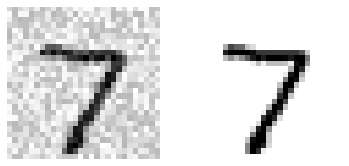

In [66]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Train classifier and perform cleaning

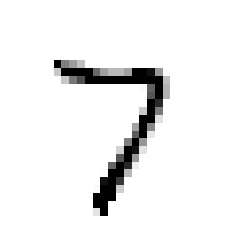

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)